# **Hotel Cancellation Prediction**



**1. Import**

In [1]:
import pandas as pd
import numpy as np

**2. Dataset**

In [2]:
data = pd.read_csv('booking.csv')

data.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


**3. Drop Useless Data**

In [3]:
data.drop(['Booking_ID', 'P-not-C'], axis=1, inplace=True)


**4. Set X & Y**

In [4]:
# Convert 'date of reservation' to datetime
data['date of reservation'] = pd.to_datetime(data['date of reservation'],errors='coerce')

# Create new features based on 'date of reservation'
data['reservation_year'] = data['date of reservation'].dt.year
data['reservation_month'] = data['date of reservation'].dt.month
data['reservation_day'] = data['date of reservation'].dt.day
data['reservation_dayofweek'] = data['date of reservation'].dt.dayofweek

# Drop the original 'date of reservation' column
data = data.drop(['date of reservation'], axis=1)

data.dropna(subset=['reservation_year', 'reservation_month', 'reservation_day', 'reservation_dayofweek'], inplace=True)

# Create dummy variables and set X & Y
X = data.drop(['booking status'], axis=1)
y = data['booking status']
X = pd.get_dummies(X)

**5. Train, Validation and Test Split**

In [5]:
from sklearn.model_selection import train_test_split

X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train1, y_train1, test_size=0.1, random_state=42)

print(X_train.shape[0])
print(len(y_train))

29360
29360


**6. Standardize 'Average Price'**

In [6]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
s = StandardScaler()

# Standardize the 'average price' column on the training set
s.fit(X_train[['average price']])

# Transform the 'average price' column on the training and validation sets
x_train_std = s.transform(X_train[['average price']])
x_valid_std = s.transform(X_valid[['average price']])

# Create DataFrames from standardized data
x_train_std = pd.DataFrame(x_train_std, columns=['average price'])
x_valid_std = pd.DataFrame(x_valid_std, columns=['average price'])

# Drop the 'average price' column from x_train_std and x_valid_std
X_train = X_train.drop(columns=['average price'])
X_valid = X_valid.drop(columns=['average price'])

# Reset the index of DataFrames before concatenation
X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)
x_train_std.reset_index(drop=True, inplace=True)
x_valid_std.reset_index(drop=True, inplace=True)

# Concatenate standardized data with the rest of the data
X_train = pd.concat([x_train_std, X_train], axis=1)
X_valid = pd.concat([x_valid_std, X_valid], axis=1)

# Print the first few rows of concatenated DataFrames
print(X_train.head())
print(X_valid.head())


   average price  number of adults  number of children  \
0      -0.805801                 2                   0   
1      -0.200849                 2                   0   
2      -1.033012                 1                   0   
3      -0.712076                 2                   0   
4      -0.386879                 2                   0   

   number of weekend nights  number of week nights  car parking space  \
0                         0                      3                  0   
1                         1                      1                  0   
2                         2                      0                  1   
3                         2                      0                  0   
4                         1                      2                  0   

   lead time  repeated  P-C  special requests  ...  room type_Room_Type 3  \
0        146         0    0                 0  ...                  False   
1         57         0    0                 0  ...        

**7. K-Nearest Neighbors**

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define a list of parameters to explore
parameters = {'n_neighbors': [3, 5, 7, 9, 11], 'metric': ('hamming', 'euclidean', 'manhattan')}

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV with the KNN classifier and parameters
grid_search = GridSearchCV(knn, parameters, cv=5, scoring='accuracy', verbose=3)

# Fit GridSearchCV on the data
grid_search.fit(X_train, y_train)

# Best model and best parameters
best_knn_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best model:", best_knn_model)
print("Best parameters:", best_params)
print("Best score:", best_score)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END .....metric=hamming, n_neighbors=3;, score=0.809 total time=   1.9s
[CV 2/5] END .....metric=hamming, n_neighbors=3;, score=0.814 total time=   1.9s
[CV 3/5] END .....metric=hamming, n_neighbors=3;, score=0.815 total time=   2.0s
[CV 4/5] END .....metric=hamming, n_neighbors=3;, score=0.817 total time=   2.1s
[CV 5/5] END .....metric=hamming, n_neighbors=3;, score=0.808 total time=   2.0s
[CV 1/5] END .....metric=hamming, n_neighbors=5;, score=0.814 total time=   2.7s
[CV 2/5] END .....metric=hamming, n_neighbors=5;, score=0.816 total time=   2.6s
[CV 3/5] END .....metric=hamming, n_neighbors=5;, score=0.812 total time=   2.7s
[CV 4/5] END .....metric=hamming, n_neighbors=5;, score=0.821 total time=   2.7s
[CV 5/5] END .....metric=hamming, n_neighbors=5;, score=0.811 total time=   2.9s
[CV 1/5] END .....metric=hamming, n_neighbors=7;, score=0.817 total time=   2.8s
[CV 2/5] END .....metric=hamming, n_neighbors=7;

**8. Support Vector Machines**

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define a list of parameters to explore
parameters = {'C': [0.1, 1, 10],
              'kernel': ['linear', 'rbf', 'poly'],
              'gamma': ['scale']}

# Initialize the SVM classifier
svm_classifier = SVC()

# Initialize GridSearchCV with the SVM classifier and parameters
grid_search_svm = GridSearchCV(svm_classifier, parameters, cv=5, scoring='accuracy', verbose=3)

# Fit GridSearchCV on the data
grid_search_svm.fit(X_train, y_train)

# Best model and best parameters
best_svm_model = grid_search_svm.best_estimator_
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_

print("Best SVM model:", best_svm_model)
print("Best SVM parameters:", best_params_svm)
print("Best SVM score:", best_score_svm)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.798 total time=  12.7s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.804 total time=  11.3s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.800 total time=  11.1s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.802 total time=  10.9s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.789 total time=  11.9s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.739 total time=  25.0s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.744 total time=  22.5s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.747 total time=  22.0s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.743 total time=  22.3s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.742 total time=  22.1s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.742 total time=  15.0s
[CV 2/5] END ...C=0.1, gamma=scale, kernel=poly;,

**9. Decision Tree**

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the list of parameters to explore
parameters = {'criterion': ['gini', 'entropy'],
              'max_depth': [None, 10, 20, 30, 40, 50],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# Initialize the decision tree classifier
tree_classifier = DecisionTreeClassifier()

# Initialize GridSearchCV with the decision tree classifier and parameters
grid_search_tree = GridSearchCV(tree_classifier, parameters, cv=5, scoring='accuracy', verbose=3)

# Fit GridSearchCV on the data
grid_search_tree.fit(X_train, y_train)

# Best model and best parameters
best_tree_model = grid_search_tree.best_estimator_
best_params_tree = grid_search_tree.best_params_
best_score_tree = grid_search_tree.best_score_

print("Best Decision Tree model:", best_tree_model)
print("Best Decision Tree parameters:", best_params_tree)
print("Best Decision Tree score:", best_score_tree)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.860 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.863 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.868 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.865 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.862 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.857 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.857 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.866 total time= 

**10. Test Best Solutions**

In [18]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
s = StandardScaler()

# Standardize the 'average price' column on the training set
s.fit(X_train1[['average price']])

# Transform the 'average price' column on the training and validation sets
x_train_std = s.transform(X_train1[['average price']])
x_test_std = s.transform(X_test[['average price']])

# Create DataFrames from standardized data
x_train_std = pd.DataFrame(x_train_std, columns=['average price'])
x_test_std = pd.DataFrame(x_test_std, columns=['average price'])

# Drop the 'average price' column from x_train_std and x_test_std
X_train1 = X_train1.drop(columns=['average price'])
X_test = X_test.drop(columns=['average price'])

# Reset the index of DataFrames before concatenation
X_train1.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
x_train_std.reset_index(drop=True, inplace=True)
x_test_std.reset_index(drop=True, inplace=True)

# Concatenate standardized data with the rest of the data
X_train1 = pd.concat([x_train_std, X_train1], axis=1)
X_test = pd.concat([x_test_std, X_test], axis=1)

# Print the first few rows of concatenated DataFrames
print(X_train1.head())
print(X_test.head())

   average price  number of adults  number of children  \
0      -0.040411                 2                   0   
1      -0.612680                 2                   0   
2      -0.752189                 1                   0   
3       0.585953                 2                   0   
4       0.158887                 2                   0   

   number of weekend nights  number of week nights  car parking space  \
0                         2                      2                  0   
1                         0                      1                  0   
2                         1                      1                  0   
3                         0                      3                  0   
4                         2                      1                  0   

   lead time  repeated  P-C  special requests  ...  room type_Room_Type 3  \
0          4         0    0                 1  ...                  False   
1         30         0    0                 0  ...        

In [19]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN classifier with the best parameters
best_knn_model = KNeighborsClassifier(n_neighbors=11, metric='hamming')

# Train the final KNN model on the training data
best_knn_model.fit(X_train1, y_train1)

# Evaluate the performance of the final KNN model on the test data
knn_accuracy = best_knn_model.score(X_test, y_test)
print("Accuracy of the final KNN model:", knn_accuracy)

Accuracy of the final KNN model: 0.8173793103448276


In [20]:
from sklearn.svm import SVC

# Initialize the SVM classifier with the best parameters
best_svm_model = SVC(C=0.1, kernel='linear', gamma='scale')

# Train the final SVM model on the training data
best_svm_model.fit(X_train1, y_train1)

# Evaluate the performance of the final SVM model on the test data
svm_accuracy = best_svm_model.score(X_test, y_test)
print("Accuracy of the final SVM model:", svm_accuracy)

Accuracy of the final SVM model: 0.791448275862069


In [21]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the DTC with the best parameters
best_dtc_model = DecisionTreeClassifier(max_depth=10, criterion='gini', min_samples_leaf=1, min_samples_split=2)

# Train the final DTC model on the training data
best_dtc_model.fit(X_train1, y_train1)

# Evaluate the performance of the final DTC model on the test data
dtc_accuracy = best_dtc_model.score(X_test, y_test)
print("Accuracy of the final LDA model:", dtc_accuracy)

Accuracy of the final LDA model: 0.864


In [22]:
# Evaluation of the best KNN model on the test set
knn_test_score = best_knn_model.score(X_test, y_test)
print("Accuracy of the KNN model on the test set:", knn_test_score)

# Evaluation of the best SVM model on the test set
svm_test_score = best_svm_model.score(X_test, y_test)
print("Accuracy of the SVM model on the test set:", svm_test_score)

# Evaluation of the best DTC model on the test set
dtc_test_score = best_dtc_model.score(X_test, y_test)
print("Accuracy of the Decision Tree Classifier model on the test set:", dtc_test_score)

Accuracy of the KNN model on the test set: 0.8173793103448276
Accuracy of the SVM model on the test set: 0.791448275862069
Accuracy of the Decision Tree Classifier model on the test set: 0.864


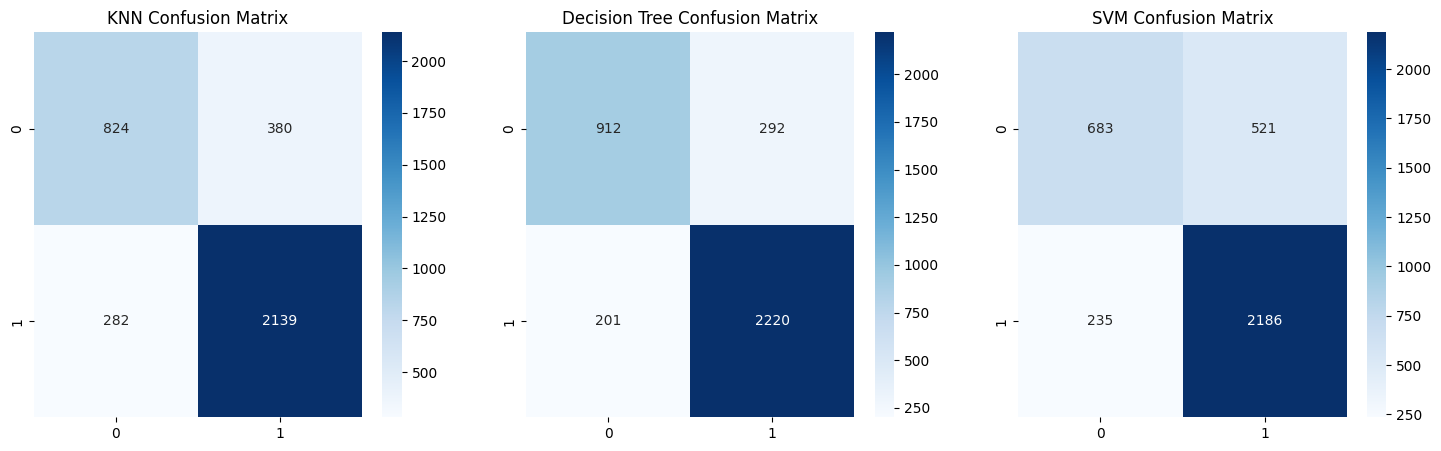

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions using the best KNN model
knn_pred = best_knn_model.predict(X_test)
knn_conf_matrix = confusion_matrix(y_test, knn_pred)

# Predictions using the best DTC model
dtc_pred = best_dtc_model.predict(X_test)
dtc_conf_matrix = confusion_matrix(y_test, dtc_pred)

# Predictions using the best SVM model
svm_pred = best_svm_model.predict(X_test)
svm_conf_matrix = confusion_matrix(y_test, svm_pred)

# Display confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# KNN confusion matrix
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap="Blues", ax=axes[0])
axes[0].set_title('KNN Confusion Matrix')

# DTC confusion matrix
sns.heatmap(dtc_conf_matrix, annot=True, fmt='d', cmap="Blues", ax=axes[1])
axes[1].set_title('Decision Tree Confusion Matrix')

# SVM confusion matrix
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap="Blues", ax=axes[2])
axes[2].set_title('SVM Confusion Matrix')

plt.show()

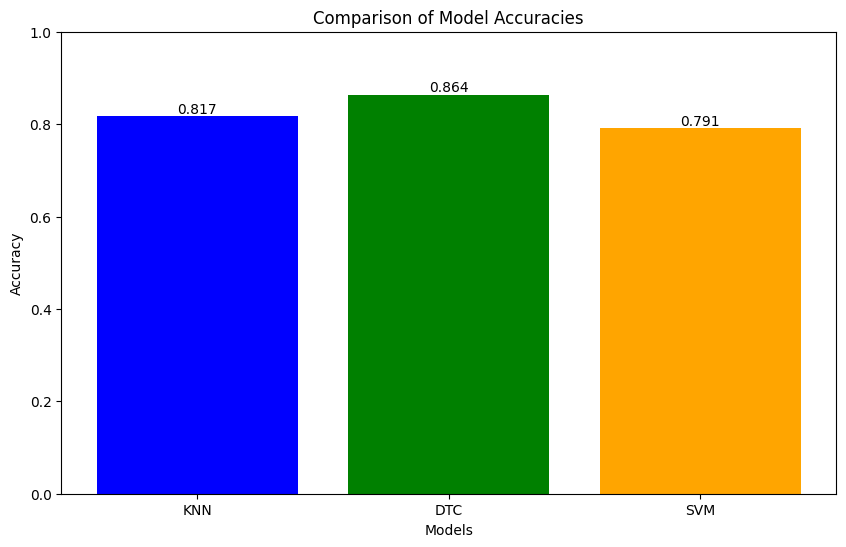

In [24]:
from sklearn.metrics import accuracy_score

# Calculating model accuracies
accuracy_knn = accuracy_score(y_test, knn_pred)
accuracy_dtc = accuracy_score(y_test, dtc_pred)
accuracy_svm = accuracy_score(y_test, svm_pred)

accuracies = [accuracy_knn, accuracy_dtc, accuracy_svm]
models = ['KNN', 'DTC', 'SVM']

# Creating a bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])

# Adding title and labels
plt.title('Comparison of Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Displaying values above the bars
for index, value in enumerate(accuracies):
    plt.text(index, value, str(round(value, 3)), ha='center', va='bottom')

# Displaying the chart
plt.ylim(0, 1)
plt.show()

**11. Test All Models With LDA**

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Initialize the StandardScaler
s = StandardScaler()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the 'average price' column on the training set
s.fit(X_train[['average price']])

# Transform the 'average price' column on the training and testing sets
x_train_std = s.transform(X_train[['average price']])
x_test_std = s.transform(X_test[['average price']])

# Create DataFrames from standardized data
x_train_std = pd.DataFrame(x_train_std, columns=['average price'])
x_test_std = pd.DataFrame(x_test_std, columns=['average price'])

# Drop the 'average price' column from x_train_std and x_test_std
X_train = X_train.drop(columns=['average price'])
X_test = X_test.drop(columns=['average price'])

# Reset the index of DataFrames before concatenation
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
x_train_std.reset_index(drop=True, inplace=True)
x_test_std.reset_index(drop=True, inplace=True)

# Concatenate standardized data with the rest of the data
X_train = pd.concat([x_train_std, X_train], axis=1)
X_test = pd.concat([x_test_std, X_test], axis=1)

# Print the first few rows of concatenated DataFrames
print(X_train.head())
print(X_test.head())

   average price  number of adults  number of children  \
0      -1.128185                 2                   0   
1      -1.092664                 1                   0   
2       0.937158                 3                   0   
3      -0.495908                 1                   0   
4       0.711528                 0                   2   

   number of weekend nights  number of week nights  car parking space  \
0                         2                      2                  0   
1                         0                      1                  0   
2                         1                      3                  0   
3                         1                      4                  0   
4                         2                      4                  0   

   lead time  repeated  P-C  special requests  ...  room type_Room_Type 3  \
0         50         0    0                 0  ...                  False   
1          8         1    1                 1  ...        

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Initialize the LDA model
lda = LinearDiscriminantAnalysis(n_components=1)

# Fit the LDA model only on the training set
X_train_lda = lda.fit_transform(X_train, y_train)

# Transform the testing set using the trained LDA model
X_test_lda = lda.transform(X_test)

**12. KNN With LDA**

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define a list of parameters to explore
parameters = {'n_neighbors': [3, 5, 7, 9, 11], 'metric': ('hamming', 'euclidean', 'manhattan')}

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV with the KNN classifier and parameters
grid_search = GridSearchCV(knn, parameters, cv=5, scoring='accuracy', verbose=3)

# Fit GridSearchCV on the data
grid_search.fit(X_train_lda, y_train)

# Best model and best parameters
best_knn_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best model:", best_knn_model)
print("Best parameters:", best_params)
print("Best score:", best_score)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END .....metric=hamming, n_neighbors=3;, score=0.441 total time=   1.2s
[CV 2/5] END .....metric=hamming, n_neighbors=3;, score=0.448 total time=   1.2s
[CV 3/5] END .....metric=hamming, n_neighbors=3;, score=0.447 total time=   1.2s
[CV 4/5] END .....metric=hamming, n_neighbors=3;, score=0.446 total time=   1.2s
[CV 5/5] END .....metric=hamming, n_neighbors=3;, score=0.447 total time=   1.2s
[CV 1/5] END .....metric=hamming, n_neighbors=5;, score=0.426 total time=   1.2s
[CV 2/5] END .....metric=hamming, n_neighbors=5;, score=0.428 total time=   1.2s
[CV 3/5] END .....metric=hamming, n_neighbors=5;, score=0.428 total time=   1.2s
[CV 4/5] END .....metric=hamming, n_neighbors=5;, score=0.429 total time=   1.2s
[CV 5/5] END .....metric=hamming, n_neighbors=5;, score=0.427 total time=   1.2s
[CV 1/5] END .....metric=hamming, n_neighbors=7;, score=0.416 total time=   1.2s
[CV 2/5] END .....metric=hamming, n_neighbors=7;

**13. SVM With LDA**

In [35]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define a list of parameters to explore
parameters = {'C': [0.1, 1, 10],
              'kernel': ['linear', 'rbf', 'poly'],
              'gamma': ['scale']}

# Initialize the SVM classifier
svm_classifier = SVC()

# Initialize GridSearchCV with the SVM classifier and parameters
grid_search_svm = GridSearchCV(svm_classifier, parameters, cv=5, scoring='accuracy', verbose=3)

# Fit GridSearchCV on the data
grid_search_svm.fit(X_train_lda, y_train)

# Best model and best parameters
best_svm_model = grid_search_svm.best_estimator_
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_

print("Best SVM model:", best_svm_model)
print("Best SVM parameters:", best_params_svm)
print("Best SVM score:", best_score_svm)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.793 total time=   6.9s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.805 total time=   7.0s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.798 total time=   7.0s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.800 total time=   7.0s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.803 total time=   6.9s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.795 total time=  11.3s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.803 total time=  11.3s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.798 total time=  11.2s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.801 total time=  11.5s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.803 total time=  11.1s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.761 total time=   7.1s
[CV 2/5] END ...C=0.1, gamma=scale, kernel=poly;,

**14. Decision Tree Classifier With LDA**

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the list of parameters to explore
parameters = {'criterion': ['gini', 'entropy'],
              'max_depth': [None, 10, 20, 30, 40, 50],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# Initialize the decision tree classifier
tree_classifier = DecisionTreeClassifier()

# Initialize GridSearchCV with the decision tree classifier and parameters
grid_search_tree = GridSearchCV(tree_classifier, parameters, cv=5, scoring='accuracy', verbose=3)

# Fit GridSearchCV on the data
grid_search_tree.fit(X_train_lda, y_train)

# Best model and best parameters
best_tree_model = grid_search_tree.best_estimator_
best_params_tree = grid_search_tree.best_params_
best_score_tree = grid_search_tree.best_score_

print("Best Decision Tree model:", best_tree_model)
print("Best Decision Tree parameters:", best_params_tree)
print("Best Decision Tree score:", best_score_tree)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.813 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.819 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.812 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.812 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.819 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.808 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.817 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.808 total time= 

**15. Test Best Solutions With LDA**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN classifier with the best parameters
best_knn_model_LDA = KNeighborsClassifier(n_neighbors=7, metric='euclidean')

# Train the final KNN model on the training data
best_knn_model_LDA.fit(X_train_lda, y_train)

# Evaluate the performance of the final KNN model on the test data
knn_accuracy_LDA = best_knn_model_LDA.score(X_test_lda, y_test)
print("Accuracy of the final KNN model:", knn_accuracy_LDA)

In [ ]:
from sklearn.svm import SVC

# Initialize the SVM classifier with the best parameters
best_svm_model_LDA = SVC(C=10, kernel='rbf', gamma='scale')

# Train the final SVM model on the training data
best_svm_model_LDA.fit(X_train_lda, y_train)

# Evaluate the performance of the final SVM model on the test data
svm_accuracy_LDA = best_svm_model_LDA.score(X_test_lda, y_test)
print("Accuracy of the final SVM model:", svm_accuracy_LDA)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the DTC with the best parameters
best_dtc_model_LDA = DecisionTreeClassifier(max_depth=20, criterion='entropy', min_samples_leaf=1, min_samples_split=2)

# Train the final DTC model on the training data
best_dtc_model_LDA.fit(X_train_lda, y_train)

# Evaluate the performance of the final DTC model on the test data
dtc_accuracy_LDA = best_dtc_model_LDA.score(X_test_lda, y_test)
print("Accuracy of the final LDA model:", dtc_accuracy_LDA)

In [ ]:
# Evaluation of the best KNN model on the test set
knn_test_score_LDA = best_knn_model_LDA.score(X_test_lda, y_test)
print("Accuracy of the KNN model on the test set:", knn_test_score_LDA)

# Evaluation of the best SVM model on the test set
svm_test_score_LDA = best_svm_model_LDA.score(X_test_lda, y_test)
print("Accuracy of the SVM model on the test set:", svm_test_score_LDA)

# Evaluation of the best DTC model on the test set
dtc_test_score_LDA = best_dtc_model_LDA.score(X_test_lda, y_test)
print("Accuracy of the Decision Tree Classifier model on the test set:", dtc_test_score_LDA)

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions using the best KNN model
knn_pred_LDA = best_knn_model_LDA.predict(X_test_lda)
knn_conf_matrix_LDA = confusion_matrix(y_test, knn_pred_LDA)

# Predictions using the best DTC model
dtc_pred_LDA = best_dtc_model_LDA.predict(X_test_lda)
dtc_conf_matrix_LDA = confusion_matrix(y_test, dtc_pred_LDA)

# Predictions using the best SVM model
svm_pred_LDA = best_svm_model.predict(X_test_lda)
svm_conf_matrix_LDA = confusion_matrix(y_test, svm_pred_LDA)

# Display confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# KNN confusion matrix
sns.heatmap(knn_conf_matrix_LDA, annot=True, fmt='d', cmap="Blues", ax=axes[0])
axes[0].set_title('KNN Confusion Matrix With LDA')

# DTC confusion matrix
sns.heatmap(dtc_conf_matrix_LDA, annot=True, fmt='d', cmap="Blues", ax=axes[1])
axes[1].set_title('Decision Tree Confusion Matrix With LDA')

# SVM confusion matrix
sns.heatmap(svm_conf_matrix_LDA, annot=True, fmt='d', cmap="Blues", ax=axes[2])
axes[2].set_title('SVM Confusion Matrix With LDA')

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# Calculating model accuracies
accuracy_knn_LDA = accuracy_score(y_test, knn_pred_LDA)
accuracy_dtc_LDA = accuracy_score(y_test, dtc_pred_LDA)
accuracy_svm_LDA = accuracy_score(y_test, svm_pred_LDA)

accuracies_LDA = [accuracy_knn_LDA, accuracy_dtc_LDA, accuracy_svm_LDA]
models = ['KNN', 'DTC', 'SVM']

# Creating a bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies_LDA, color=['blue', 'green', 'orange'])

# Adding title and labels
plt.title('Comparison of Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Displaying values above the bars
for index, value in enumerate(accuracies_LDA):
    plt.text(index, value, str(round(value, 3)), ha='center', va='bottom')

# Displaying the chart
plt.ylim(0, 1)
plt.show()